<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.10.12

Author: © 2021 Rūta Buckiūnaitė

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:

1. [Does higher % of tertiary educated population correlate with total vaccinations per hundred in Europe?](#Q1)
2. [Did mandatory green pass in Lithuania affect the number of new cases and vaccinations?](#Q2)
3. [Can we predict housing price changes in Lithuania based on COVID cases?](#Q3)

We additionally uses data from:
* https://appsso.eurostat.ec.europa.eu/nui/submitViewTableAction.do

* https://osp.stat.gov.lt/statistiniu-rodikliu-analize?hash=94e5a6a5-bc13-4405-886b-596caa596a72#/


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

Import necessary libraries

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from statistics import mean, stdev
from math import sqrt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Load COVID-19 data

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [2]:
#import requests
#fname = 'owid-covid-data.csv'
#url = 'https://covid.ourworldindata.org/data/' + fname
#r = requests.get(url)
#open(fname, 'wb').write(r.content)

Load the file to Pandas.

In [3]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

Check the columns available.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123030 entries, 0 to 123029
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 123030 non-null  object        
 1   continent                                117443 non-null  object        
 2   location                                 123030 non-null  object        
 3   date                                     123030 non-null  datetime64[ns]
 4   total_cases                              116528 non-null  float64       
 5   new_cases                                116524 non-null  float64       
 6   new_cases_smoothed                       115510 non-null  float64       
 7   total_deaths                             105683 non-null  float64       
 8   new_deaths                               105836 non-null  float64       
 9   new_deaths_smoothed       

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

### Filter data for 1st question. 

Let's get the COVID data from Europe and display it.

In [5]:
df_vacc = df[df.continent == 'Europe']
df_vacc.set_index('location', inplace=True)
df_vacc.head()

,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
location,,,,,,,,,,,,,,,,,,,,,
Albania,ALB,Europe,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
Albania,ALB,Europe,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
Albania,ALB,Europe,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
Albania,ALB,Europe,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
Albania,ALB,Europe,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,51.2,NaN,2.89,78.57,0.795,-190.8,-4.34,2.88,-66.412942


We will only need the most recent available rows from each European country, so let's group the data by locations.

In [6]:
df_maximum = df_vacc.groupby('location').last()
df_maximum

,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
location,,,,,,,,,,,,,,,,,,,,,
Albania,ALB,Europe,2021-10-11,175163.0,195.0,481.286,2777.0,9.0,9.143,60970.074,...,7.1,51.2,NaN,2.890,78.57,0.795,9850.4,29.68,-6.51,3428.689973
Andorra,AND,Europe,2021-10-11,15307.0,16.0,5.714,130.0,0.0,0.000,197882.462,...,29.0,37.8,NaN,NaN,83.73,0.868,89.6,27.20,31.41,1158.311141
Austria,AUT,Europe,2021-10-11,762538.0,1320.0,1758.429,11106.0,10.0,10.286,84322.894,...,28.4,30.9,NaN,7.370,81.54,0.922,10780.2,7.50,9.42,1192.094899
Belarus,BLR,Europe,2021-10-11,559715.0,1943.0,1981.714,4304.0,15.0,14.857,59273.841,...,10.5,46.1,NaN,11.000,74.79,0.823,31283.9,20.45,1.80,3312.966284
Belgium,BEL,Europe,2021-10-11,1266562.0,5460.0,2100.714,25695.0,20.0,9.000,108882.878,...,25.1,31.4,NaN,5.640,81.63,0.931,15952.5,8.35,-2.43,1371.392878
Bosnia and Herzegovina,BIH,Europe,2021-10-11,241227.0,1133.0,601.429,10965.0,102.0,34.143,73917.583,...,30.2,47.7,97.164,3.500,77.40,0.780,12984.2,23.58,18.50,3978.661904
Bulgaria,BGR,Europe,2021-10-11,524333.0,3471.0,2219.000,21813.0,157.0,85.286,76027.146,...,30.1,44.4,NaN,7.454,75.05,0.816,36655.3,19.48,49.62,5314.938909
Croatia,HRV,Europe,2021-10-11,418028.0,170.0,1301.429,8778.0,6.0,13.286,102416.249,...,34.3,39.9,NaN,5.540,78.49,0.851,9318.5,10.72,1.35,2283.018882
Cyprus,CYP,Europe,2021-10-11,121364.0,372.0,123.714,560.0,1.0,0.857,135450.137,...,19.6,52.7,NaN,3.400,80.98,0.887,36.5,0.36,-31.13,41.103372


### Filter data for 3rd question. 

 Let's split the COVID dataset for 2020 and 2021. For each year let's add a `quarter` feature to match the house prices changes dataset.

In [7]:
df_ltCases = df[df.location == 'Lithuania'][['date', 'new_cases']]
df_ltCases['quarter'] = df_ltCases['date'].dt.quarter
df_ltCases = df_ltCases.loc[df_ltCases["date"] > '2021-01-01']

In [8]:
df_ltCases2 = df[df.location == 'Lithuania'][['date', 'new_cases']]
df_ltCases2['quarter'] = df_ltCases2['date'].dt.quarter
df_ltCases2 = df_ltCases2.loc[df_ltCases2["date"] < '2021-01-01']

Now let's group each data frame by `quarter` and change it's name to match the housing price dataset so we can merge the two data frames later.

In [9]:
df_ltCasesGrp = df_ltCases.groupby('quarter').mean('new_cases')   

In [10]:
df_ltCasesGrp2 = df_ltCases2.groupby('quarter').mean('new_cases')   

In [11]:
df_ltCasesGrp.rename(index={1: '2021K1', 2: '2021K2', 3: '2021K3', 4: '2021K4'},inplace=True)

In [12]:
df_ltCasesGrp2.rename(index={1: '2020K1', 2: '2020K2', 3: '2020K3', 4: '2020K4'},inplace=True)

Let's concat the two spilt dataframe into one.

In [13]:
df_ltCasesGrpMerge = pd.concat([df_ltCasesGrp2, df_ltCasesGrp])
df_ltCasesGrpMerge

,new_cases
quarter,
2020K1,14.625000
2020K2,14.769231
2020K3,31.260870
2020K4,1492.032609
2021K1,794.258427
2021K2,688.461538
2021K3,575.152174
2021K4,1964.181818


### Load population by educational attainment level data

Load the file to Pandas

In [14]:
url = "educational-attainment-level.csv" 
df_edu = pd.read_csv(url)

In [15]:
df_edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   TIME                1452 non-null   int64 
 1   GEO                 1452 non-null   object
 2   SEX                 1452 non-null   object
 3   UNIT                1452 non-null   object
 4   AGE                 1452 non-null   object
 5   ISCED11             1452 non-null   object
 6   Value               1452 non-null   object
 7   Flag and Footnotes  276 non-null    object
dtypes: int64(1), object(7)
memory usage: 90.9+ KB


More information about the columns can be found [here](./edat_lfse_04_Label.csv).

We will only be looking at the data of % of people that have achieved higher education(Tertiary education (levels 5-8)) at the time this data was taken. Let's also rename the column `GEO` to `location` for later use.

In [16]:
df_edu = df_edu.rename(columns={"GEO": "location"})
df_higher = df_edu[df_edu.ISCED11 == 'Tertiary education (levels 5-8)'][['TIME', 'location', 'ISCED11', 'Value']]
df_higher_by_time = df_higher[df_higher.TIME == 2015][['Value', 'location']]
df_higher_by_time.set_index('location', inplace = True)

It looks like the `Value` column data type is an object so let's change it to a numeric type and display the necessary columns. 

In [17]:
df_higher_by_time['Value'] = pd.to_numeric(df_higher_by_time['Value'])
df_higher_by_time.head(10)

,Value
location,
Austria,30.6
Belgium,36.9
Bulgaria,27.5
Switzerland,39.8
Cyprus,40.5
Czechia,22.2
Germany (until 1990 former territory of the FRG),27.6
Denmark,36.6
Estonia,38.1


Let's change Germany (until 1990 former territory of the FRG) to Germany to make the location names even with COVID dataset.

In [18]:
df_higher_by_time = df_higher_by_time.rename(index={'Germany (until 1990 former territory of the FRG)': 'Germany'})

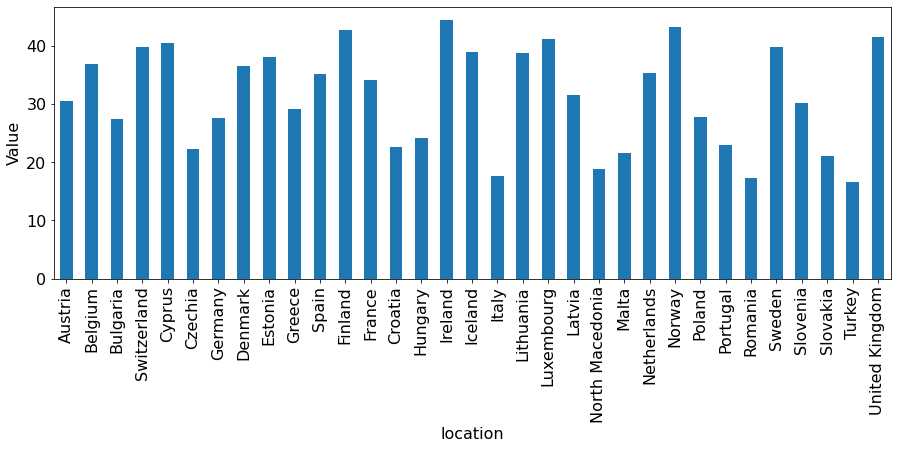

In [19]:
df_higher_by_time.plot.bar(xlabel = 'location', ylabel = 'Value', legend = 0, figsize = (15, 5), fontsize = 16)
plt.xlabel('location', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.show()

### Merging the COVID-19 and population by educational attainment level data frames

Let's inner join the COVID and educational level datasets.

In [20]:
df_educatedVaccinations = df_higher_by_time.merge(df_maximum.drop_duplicates(), on = ['location'], indicator = True)
df_educatedVaccinations.head()

,Value,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,_merge
location,,,,,,,,,,,,,,,,,,,,,
Austria,30.6,AUT,Europe,2021-10-11,762538.0,1320.0,1758.429,11106.0,10.0,10.286,...,30.9,NaN,7.370,81.54,0.922,10780.2,7.50,9.42,1192.094899,both
Belgium,36.9,BEL,Europe,2021-10-11,1266562.0,5460.0,2100.714,25695.0,20.0,9.000,...,31.4,NaN,5.640,81.63,0.931,15952.5,8.35,-2.43,1371.392878,both
Bulgaria,27.5,BGR,Europe,2021-10-11,524333.0,3471.0,2219.000,21813.0,157.0,85.286,...,44.4,NaN,7.454,75.05,0.816,36655.3,19.48,49.62,5314.938909,both
Switzerland,39.8,CHE,Europe,2021-10-11,850684.0,2266.0,925.000,11133.0,13.0,4.286,...,28.9,NaN,4.530,83.78,0.955,8108.0,6.88,-3.35,930.297238,both
Cyprus,40.5,CYP,Europe,2021-10-11,121364.0,372.0,123.714,560.0,1.0,0.857,...,52.7,NaN,3.400,80.98,0.887,36.5,0.36,-31.13,41.103372,both


### Load the price changes of housing in Lithuania data

Load the file to Pandas

In [21]:
url = "housing-price-change.csv" 
df_house = pd.read_csv(url)

In [22]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Laikotarpis                             20 non-null     object 
 1   Rodiklis                                20 non-null     object 
 2   Išlaidų būstui kategorijos:Kodas        20 non-null     object 
 3   Išlaidų būstui kategorijos:Pavadinimas  20 non-null     object 
 4   Būsto tipas                             20 non-null     object 
 5   Lyginimas                               20 non-null     object 
 6   Teritorinis lygmuo                      20 non-null     object 
 7   Matavimo vienetai                       20 non-null     object 
 8   Reikšmė                                 20 non-null     float64
dtypes: float64(1), object(8)
memory usage: 1.5+ KB


For convenience let's change the relevant lithuanian column names to english.

In [23]:
df_house = df_house.rename(columns={"Laikotarpis": "quarter", "Reikšmė": "price_change"})

Display the necessary data.

In [24]:
df_ltPrices = df_house[df_house.quarter >= '2020K1'][['quarter', 'price_change']]
df_ltPrices.set_index('quarter', inplace=True)
df_ltPrices

,price_change
quarter,
2021K2,3.4
2021K1,5.0
2020K4,3.9
2020K3,0.4
2020K2,2.2
2020K1,2.6


Merge COVID `new_cases` and housing `price_change`.

In [25]:
df_housePriceChange = df_ltPrices.merge(df_ltCasesGrpMerge, on = ['quarter'], how = 'right', indicator = True).dropna()
df_housePriceChange

,price_change,new_cases,_merge
quarter,,,
2020K1,2.6,14.625000,both
2020K2,2.2,14.769231,both
2020K3,0.4,31.260870,both
2020K4,3.9,1492.032609,both
2021K1,5.0,794.258427,both
2021K2,3.4,688.461538,both


[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Does higher % of tertiary educated population correlate with total vaccinations per hundred in Europe?

Since we already merged the two datasets, let's choose some of the columns to display and organize them in an ascending order. If there are any empty values, let's drop them.

In [26]:
df_educatedVaccinationsStat = df_educatedVaccinations[['Value','total_cases', 'new_cases', 'total_cases_per_million', 
                                                       'total_deaths', 'new_deaths', 'total_deaths_per_million', 
                                                       'total_vaccinations', 'new_vaccinations', 'total_vaccinations_per_hundred', 'reproduction_rate', 'positive_rate',
                                                       'stringency_index', 'excess_mortality_cumulative_per_million']].dropna()
df_educatedVaccinationsStat.sort_values('Value', ascending=False)

,Value,total_cases,new_cases,total_cases_per_million,total_deaths,new_deaths,total_deaths_per_million,total_vaccinations,new_vaccinations,total_vaccinations_per_hundred,reproduction_rate,positive_rate,stringency_index,excess_mortality_cumulative_per_million
location,,,,,,,,,,,,,,
Ireland,44.5,404514.0,1357.0,81180.372,5280.0,0.0,1059.623,7238787.0,1310.0,145.27,0.90,0.073,44.44,186.598016
Norway,43.2,193734.0,172.0,35445.875,871.0,0.0,159.360,7874383.0,0.0,144.07,0.77,0.049,20.37,-166.787757
Finland,42.7,147297.0,1618.0,26547.840,1100.0,4.0,198.257,7786863.0,5100.0,140.35,1.15,0.049,24.07,197.391626
United Kingdom,41.6,8232327.0,39738.0,120696.017,138167.0,28.0,2025.698,94376101.0,41557.0,138.37,1.08,0.040,41.20,1710.465275
Luxembourg,41.1,79196.0,178.0,124754.653,837.0,1.0,1318.496,799074.0,6.0,125.88,1.24,0.044,34.26,53.874048
Cyprus,40.5,121364.0,372.0,135450.137,560.0,1.0,624.997,1186491.0,4419.0,132.42,0.95,0.002,46.30,41.103372
Switzerland,39.8,850684.0,2266.0,97605.942,11133.0,13.0,1277.380,10664254.0,3232.0,122.36,0.79,0.033,46.30,930.297238
Sweden,39.8,1157822.0,0.0,113957.075,14905.0,0.0,1467.005,13965508.0,31912.0,137.45,0.99,0.030,19.44,791.965953
Lithuania,38.7,353289.0,1350.0,131340.939,5248.0,17.0,1951.029,3279760.0,6014.0,121.93,1.22,0.104,30.09,4114.969467


Let's see if there's a correlation between countries having higher % of tertiary educated population and COVID statistics.

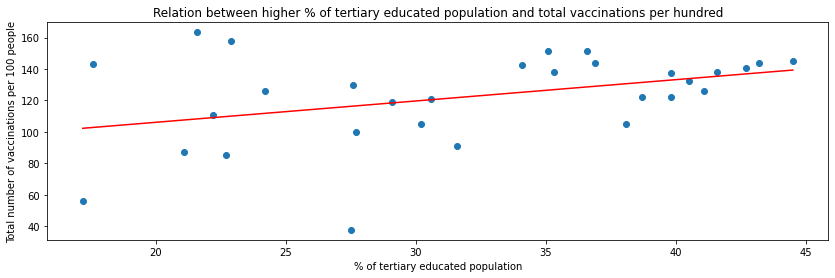

In [27]:
value = df_educatedVaccinationsStat.Value
vaccs = df_educatedVaccinationsStat.total_vaccinations_per_hundred

plt.figure(figsize=(14,4))
plt.scatter(value, vaccs)
plt.xlabel('% of tertiary educated population')
plt.ylabel('Total number of vaccinations per 100 people')

A = np.vstack([value, np.ones(len(value))]).T
y = vaccs
w, b = np.linalg.lstsq(A, y, rcond=None)[0]

x_fit = np.linspace(value.min(), value.max(), 2)
y_fit = b + w * x_fit
plt.plot(x_fit, y_fit, color='r')
plt.title('Relation between higher % of tertiary educated population and total vaccinations per hundred')
plt.show()

Let's see what the correlation is for each feature.

In [28]:
df_corr = df_educatedVaccinationsStat.corr()[["Value"]]
df_corr = df_corr.sort_values(by="Value", ascending=False)
cm = sns.light_palette("green", as_cmap=True)
df_corr.style.background_gradient(cmap=cm, axis=None)

,Value
Value,1.000000
total_vaccinations_per_hundred,0.384216
new_cases,0.153583
total_cases_per_million,0.080887
total_cases,-0.032007
total_vaccinations,-0.073968
positive_rate,-0.162837
total_deaths,-0.199352
new_vaccinations,-0.269860
reproduction_rate,-0.278174


We made an assumption that countries, that have higher % of tertiary educated population, are more likely to get vaccinated. As we can observe from the correlation value that seems to be quite true.

As we can also see, European countries with higher % of tertiary educated population have a quite strong inverse coorelations with `total_deaths_per_million` and `excess_mortality_cumulative_per_million`, which means that people from countries, who's higher % of population has achieved higher education, have less of a chance to pass away due to COVID.

We can also see that countries, who's higher % of population has achieved higher education, have experienced less restrictions(`stringency_index`) than countries, who's higher % of population hasn't achieved higher education. Despite more relaxed restrictions, COVID seems to spread at a lower pace(`reproduction_rate`) than countries with higher restrictions.

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. Did mandatory green pass in Lithuania affect the number of new cases and vaccinations?

Let's assume that the mandatory green pass in Lithuania helped more people to get vaccinated or test more often which led to discovering more COVID cases. Let's see if that assumption is true.

In [29]:
df_gpAnnouncement = datetime.datetime(2021, 8, 4) # accouncement of the date the green pass will become mandatory in some establishments
df_gpStart = datetime.datetime(2021, 9, 13) # the date the green pass became mandatory in some establishments
df_testingStart = datetime.datetime(2021, 7, 26) # the day first news appeared about mandatory testing or vaccination for some workers

df_ltPass = df[df.location == 'Lithuania'][['date', 'new_cases_smoothed', 'new_vaccinations', 'new_vaccinations_smoothed', 'new_tests_smoothed']]
df_ltPass2 = df_ltPass[df_ltPass.new_vaccinations > 0][['date', 'new_cases_smoothed', 'new_vaccinations_smoothed', 'new_tests_smoothed']]
df_ltPass3 = df_ltPass2[df_ltPass2.date > '2021-07-12'][['date', 'new_cases_smoothed', 'new_vaccinations_smoothed', 'new_tests_smoothed']]
df_ltPass3.set_index('date', inplace=True)
df_ltPass3.dropna()

,new_cases_smoothed,new_vaccinations_smoothed,new_tests_smoothed
date,,,
2021-07-13,50.286,10509.0,8302.0
2021-07-14,56.714,9445.0,8206.0
2021-07-15,66.286,8573.0,8146.0
2021-07-16,68.286,8298.0,8169.0
2021-07-17,70.714,8153.0,8278.0
...,...,...,...
2021-10-04,1696.857,5892.0,22105.0
2021-10-05,1740.571,5786.0,22088.0
2021-10-06,1851.143,5694.0,22235.0


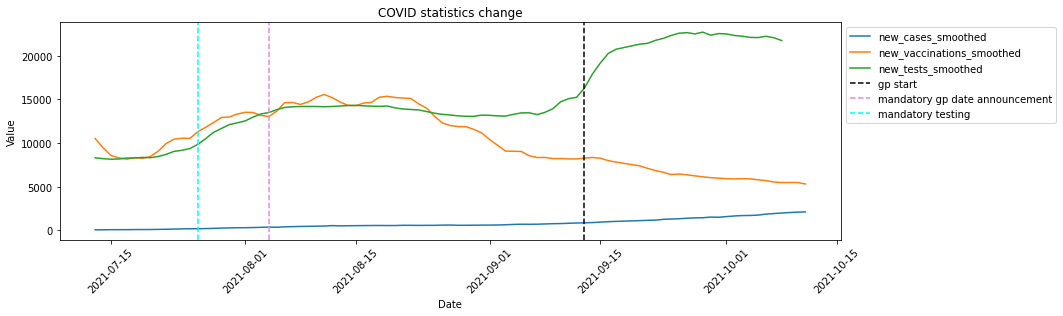

In [30]:
greenColumns = list(df_ltPass3.columns.values)
fig, ax = plt.subplots(figsize = (14, 4))
for col in greenColumns:
    ax.plot(df_ltPass3[col], label = col)

plt.axvline(x = df_gpStart, color = 'k', linestyle = '--', label = 'gp start')
plt.axvline(x = df_gpAnnouncement, color = 'violet', linestyle = '--', label = 'mandatory gp date announcement')
plt.axvline(x = df_testingStart, color = 'cyan', linestyle = '--', label = 'mandatory testing')

ax.set(xlabel='Date', ylabel='Value', title='COVID statistics change')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

As evident by the `COVID statistics change` plot above, the introduction of the mandatory green pass hasn't made a positive change that the government was probably hoping for. On the contrary while COVID cases are steadily rising, less people are getting vaccinated. One the other hand the number of tests performed got higher after the introduction of the mandatory green pass.

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. Can we predict housing price changes in Lithuania based on COVID cases?

In [31]:
df_housePriceChange.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 2020K1 to 2021K2
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price_change  6 non-null      float64 
 1   new_cases     6 non-null      float64 
 2   _merge        6 non-null      category
dtypes: category(1), float64(2)
memory usage: 282.0+ bytes


Vizualisation of the housing price change after each quarter.

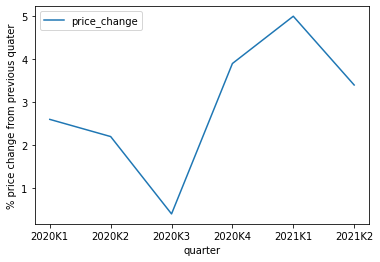

In [32]:
df_housePriceChange.plot(y = 'price_change', ylabel = "% price change from previous quater")
plt.show()

Let's see if there is a correlation between the change in housing prices and the number of new cases.

In [33]:
df_corrPrice = df_housePriceChange.corr()[["new_cases"]]
df_corrPrice

,new_cases
price_change,0.709472
new_cases,1.000000


The correlation value seems to indicate a strong correlation between these features, which means as the COVID cases rise the housing prices are very likely to rise as well.

### Predicting future change in housing prices. 

To predict the future changes I decided to model the Linear Regression between these two datasets.

Solution source: https://github.com/pb111/Simple-Linear-Regression-Project/blob/master/SLRProject.ipynb

Let's split the data into train and test sets.

In [34]:
X = df_housePriceChange['new_cases'].values
y = df_housePriceChange['price_change'].values
X = X.reshape(-1,1)
y = y.reshape(-1,1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=42)
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)

Predicting future price changes in %.

In [35]:
lm.predict(X)

array([[1.38976453],
       [1.39011396],
       [1.43006826],
       [4.96908047],
       [3.27858271],
       [3.02226855]])

Let's check if our model is a good fit for the data with standard deviation of the residuals metric.

In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1.0297051255204934

Lower RMSE value indicates a better fit. In this case a score of 1.0297051255204934 means that the predicted value is either + or - off by that score. The score we got suggests that the model is okay for this dataset.

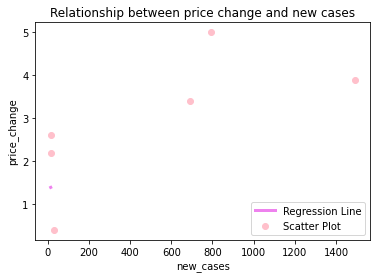

In [37]:
plt.scatter(X, y, color = 'pink', label='Scatter Plot')
plt.plot(X_test, y_pred, color = 'violet', linewidth=3, label = 'Regression Line')
plt.title('Relationship between price change and new cases')
plt.xlabel('new_cases')
plt.ylabel('price_change')
plt.legend(loc=4)
plt.show()

### Conclusion 

While writing this last problem I realised the house prices dataset I chose was too small to fit to a Linear Regression model. As evident by the `Relationship between price change and new cases` the model is not fit to predict future data.  With such as small dataset the model does not learn the relationships appropriately from the training and test data. A non-linear or more complex model might be a better choise in this case.